In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
import nbformat
import plotly.express as px


In [3]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm

# Data

In [4]:
# DATA
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv')
df.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [5]:
# CUT THE MISSING DATA TAIL
df['timeStamp'] = pd.to_datetime(df['timeStamp'])
# demand missing from 2017-08-10
df = df[df['timeStamp']<'2017-08-10']

In [6]:
# ALL DATETIMES
idx = pd.date_range(start = '2012-01-01 00:00:00', end = '2017-08-09 23:00:00', freq='H')
df = df.set_index('timeStamp')
df = df.reindex(idx)

In [7]:
# FILL MISSING VALUES
# Filling missing values with fill forward
for col in df.columns:
    df[col] = df[col].fillna(method='ffill')

In [8]:
# RESAMPLING DAILY
df_daily = df[['demand', 'precip']].resample('D').sum()
temp = df.groupby(df.index.date)['temp'].agg(min_temp = 'min', max_temp = 'max', avg_temp = 'mean')
df_daily = df_daily.join(temp)
df_daily.head()

,demand,precip,min_temp,max_temp,avg_temp
2012-01-01,118916.0,0.0597,38.78,50.77,46.510000
2012-01-02,127270.9,0.0000,33.57,49.78,40.496667
2012-01-03,146292.3,0.0000,16.47,33.14,26.672500
2012-01-04,152070.4,0.0000,13.40,31.83,20.585000
2012-01-05,147125.9,0.0000,27.31,39.16,33.577500


In [17]:
# SAVE TO CSV
current_dir = os.getcwd()
data_folder = 'Data'
file_path = os.path.join(current_dir, data_folder, 'Energy_NY_Daily.csv')
df_daily.to_csv(file_path)

<AxesSubplot:>

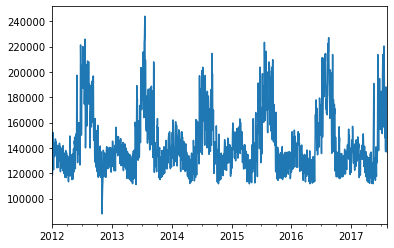

In [18]:
df_daily['demand'].plot()

<AxesSubplot:>

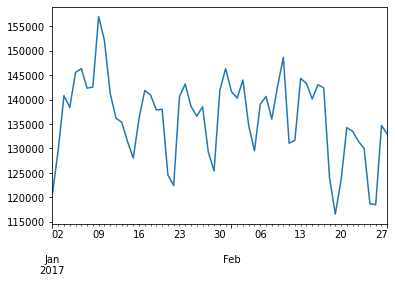

In [19]:
# Weekly seasonality
df_daily['2017-01':'2017-02']['demand'].plot()

# Modelling with pmdarima

In [20]:
train = df_daily['2012-01-01':'2017-06-30']
test = df_daily['2017-07-01':'2017-08-09']
print(train.shape)
print(test.shape)

(2008, 5)
(40, 5)


In [21]:
model1 = pm.auto_arima(train['demand'],
                      m = 7,
                      seasonal = True,
                      start_p = 0,
                      start_q = 0,
                      max_order = 7,
                      test = 'adf',
                      error_action = 'ignore',
                      suppress_warnings = True,
                      stepwise = True,
                      trace = True)

# m - number of periods in each season, e.g. 4 for quarterly data, 12 for monthly and so on. Seem not working for m = 365.
# max_order - max value of p+q+P+Q

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 7); AIC=41881.185, BIC=41903.603, Fit time=14.016 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=43223.970, BIC=43235.179, Fit time=0.258 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=42647.882, BIC=42670.300, Fit time=1.412 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=42809.447, BIC=42831.865, Fit time=1.621 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 7); AIC=42893.363, BIC=42910.176, Fit time=0.942 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 1, 7); AIC=42233.994, BIC=42262.016, Fit time=17.967 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=42697.119, BIC=42713.932, Fit time=0.947 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 2, 7); AIC=42237.338, BIC=42265.360, Fit time=17.137 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 2, 7); AIC=42245.354, BIC=42278.980, Fit time=20.438 seconds
Fit ARIMA: orde

In [22]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2008
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 7)   Log Likelihood              -20936.593
Date:                             Mon, 17 Aug 2020   AIC                          41881.185
Time:                                     11:13:51   BIC                          41903.603
Sample:                                          0   HQIC                         41889.415
                                            - 2008                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0069      0.185     -0.037      0.970      -0.370       0.356
ar.S.L7        1.0000   6.37e-05   1.57e+04      0.000       1.000       1.000
ma.S.L7       -0.9990      0.013    -75.244      0.000      -1.025      -0.973
sigma2      6.636e+07   2.33e-08   2.85e+15      0.000    6.64e+07    6.64e+07
===================================================================================
Ljung-Box (Q):                      447.73   Jarque-Bera (JB):              1836.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.12
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.92e+29. Standard errors may be unstable.
"""

In [23]:
model1.fit(train['demand'])

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True)

In [26]:
forecast = model1.predict(n_periods=test.shape[0], return_conf_int=True)
forecast

(array([168175.29206296, 165784.11896447, 181730.89222076, 184156.39833812,
        184001.3694036 , 183069.84287468, 182157.83429678, 168402.24216624,
        166011.06782361, 181957.79618618, 184383.28959432, 184228.25409298,
        183296.72284555, 182384.70950267, 168629.14317857, 166237.9675918 ,
        182184.65106075, 184610.1317597 , 184455.08969158, 183523.55372563,
        182611.53561779, 168855.99510007, 166464.81826917, 182411.45684461,
        184836.92483439, 184681.87619949, 183750.33551505, 182838.31264225,
        169082.79793086, 166691.61985582, 182638.21353786, 185063.66881851,
        184908.61361685, 183977.06821392, 183065.04057618, 169309.55167105,
        166918.37235188, 182864.92114062, 185290.36371217, 185135.30194377]),
 array([[152188.82589923, 184161.75822668],
        [143175.90528577, 188392.33264316],
        [154041.62520512, 209420.1592364 ],
        [152183.60224542, 216129.19443083],
        [148254.70701244, 219748.03179476],
        [143911.34

In [32]:
forecast_range = pd.date_range(start = test.index[0], periods = test.shape[0], freq = 'D')
forecast_range

DatetimeIndex(['2017-07-01', '2017-07-02', '2017-07-03', '2017-07-04',
               '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08',
               '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14', '2017-07-15', '2017-07-16',
               '2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20',
               '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
               '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28',
               '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
               '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09'],
              dtype='datetime64[ns]', freq='D')

In [28]:
test.head()

,demand,precip,min_temp,max_temp,avg_temp
2017-07-01,167727.891,0.0120,71.16,82.27,76.302500
2017-07-02,164529.893,0.0092,70.79,90.90,79.894583
2017-07-03,184752.935,0.0198,70.45,89.91,79.861250
2017-07-04,159836.057,0.0139,68.27,87.80,77.160833
2017-07-05,177945.266,0.0159,67.89,85.41,76.019583


In [34]:
forecast_df = pd.DataFrame(forecast[0], index = forecast_range, columns = ['prediction'])
forecast_df.head()

,prediction
2017-07-01,168175.292063
2017-07-02,165784.118964
2017-07-03,181730.892221
2017-07-04,184156.398338
2017-07-05,184001.369404


<AxesSubplot:>

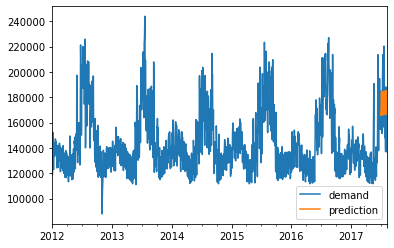

In [35]:
pd.concat([df_daily['demand'], forecast_df], axis = 1).plot()

In [36]:
# Confidence interval
lower = pd.Series(forecast[1][:,0], index = forecast_range)
upper = pd.Series(forecast[1][:,1], index = forecast_range)

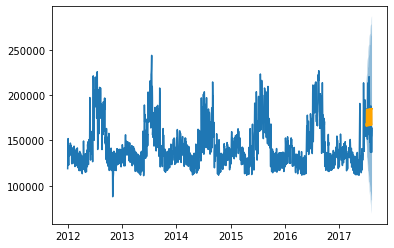

In [37]:
plt.plot(df_daily['demand'])
plt.plot(forecast_df, color = 'orange')
plt.fill_between(forecast_range, lower, upper, alpha = 1.5)

In [40]:
#out = model1.plot_diagnostics()

In [ ]:
# Far from great results mainly due to absence of covariates and m = 7 instead of 365 (or both)